This is a wish-list of models to still be implemented computationally (from Mellow & Beranek 2012):

> circular piston in a closed circular baffle
> circular piston in a rigid sphere
> 

### Troubleshooting ideas:
> Theano numeric computation: https://docs.sympy.org/latest/modules/numeric-computation.html


### Circular piston in a rigid sphere

eqn. 12.111: $D(\theta)=-\frac{4}{k^{2}R^{2}sin^{2}\alpha} \sum_{n=0}^{N} A_{n}j^{n}P_{n}cos(\theta) $

* Here the unknown is $A_{n}$
    * There is an $A_{n}$ defined in eqn. 12.102 -- it is the result of a matrix inversion $a=M^{-1}.b$

From the explanations of 12.7-12.8 we know tht $P_{n}$ is the legendre function, $j_{n}$ is the Bessel function and $h_{n}^{(2)}$ is the spherical Hankel function (eqn.2.18)

In [39]:
#from joblib import Parallel, delayed
#from gmpy2 import *
import matplotlib.pyplot as plt
import mpmath
dps = 150
mpmath.mp.dps = dps
import numpy as np
from scipy.special import jv as bessel_firstkind
#from symengine import * 
import sympy
from sympy import besselj, symbols, hankel2, legendre, sin, cos, tan, summation, I, oo, diff, pi
from sympy import factor_terms, Matrix
from sympy import Abs, lambdify, integrate, expand,integrate, Integral
from sympy.printing.theanocode import theano_function
from sympy.utilities.autowrap import autowrap
#import tqdm


In [2]:
mpmath.mp.dps

50

In [4]:
x, alpha, k, m,n, r1, R, theta = symbols('x alpha k m n r1 R theta')
r1 = (R*cos(alpha))/cos(theta)

In [5]:
legendre_func = lambdify((m, x), legendre(m, x))

In [6]:
r1

R*cos(alpha)/cos(theta)

### Getting $A_{n}$
To get $A_{n}$, we need to solve a matrix equation $\textbf{a}=\textbf{M}^{-1}.\textbf{b}$. 

Here, $M$ is given by a term that involves the $I_{mn}$ and $K_{mn}$ variables, while $b$ involves the $L_{m}$ equation. 


In [7]:
from sympy import N

In [8]:
# eqn 12.108
Lm_expr = expand(legendre(m, cos(theta))*(r1**2/R**2)*tan(theta))# 

Lm = Integral(Lm_expr, (theta,0,alpha))#.doit(meijerg=True)
Lm_func = lambdify((m,R,alpha), Lm)
# !!! Lm.subs({'alpha':np.radians(10),'m':10,'R':0.1}).evalf() --- this code runs the actual evaluation
def Lm_func_high(mv,Rv,alphav):
    return N(Lm.subs({'R':Rv,'m':mv,'alpha':alphav}),dps)

In [10]:
%%time
Lm_func_high(1,0.1,0.02)


Wall time: 1.48 s


0.00019995333608880826128958077496034040466962346673268

In [11]:
from sympy.utilities.autowrap import binary_function

In [12]:

Lm_expr = expand(legendre(m, cos(theta))*(r1**2/R**2)*tan(theta))# 

Lm = Integral(Lm_expr, (theta,0,alpha))#.doit(meijerg=True)ttt = theta*alpha - R

In [15]:
# eqn 12.107
Kmn_expr = expand(legendre(n, cos(theta))*legendre(m, cos(theta))*sin(theta) )
Kmn = Integral(Kmn_expr, (theta, alpha, pi)).doit(meijerg=True)
# Kmn.subs({'alpha':np.radians(10),'m':1,'n':10}).evalf()
Kmn_func = lambdify((m,n,alpha), Kmn)
# Kmn_func(1050,500,np.radians(10))
def Kmn_func_high(mv,nv,alphav):
    return N(Kmn.subs({'m':mv, 'n':nv, 'alpha':alphav}),dps)

In [16]:
%%time 
Kmn_func_high(20,5,np.radians(10))

Wall time: 16 s


-0.0011604202936401205578419788497048185692103074007768

In [23]:
%%time 
Kmn_func(10,20,mpmath.pi/18)

Wall time: 15.6 ms


-0.0017275474626486497

In [11]:
Kmn

Integral(sin(theta)*legendre(m, cos(theta))*legendre(n, cos(theta)), (theta, alpha, pi))

In [40]:
Imn_part1 = (n*hankel2(n-1,k*r1)-(n+1)*hankel2(n+1,k*r1))*legendre(n, cos(theta))*cos(theta)
Imn_part2 = n*(n+1)*hankel2(n, k*r1)*(legendre(n-1, cos(theta)-legendre(n+1, cos(theta))))/k*r1

In [49]:
Imn_parts = expand(Imn_part1+Imn_part2)
Imn_expr = expand(Imn_parts*legendre(m,cos(theta))*(r1**2/R**2)*tan(theta))
Imn = Integral(Imn_expr, (theta, 0, alpha)).doit(meijerg=True)
Imn_func = lambdify((alpha,R, k,m,n), Imn,'mpmath')

def Imn_func_high(alphav, Rv, kv, mv, nv):
    return N( Imn.subs({'alpha':alphav,'R':Rv, 'k':kv, 'm':mv, 'n':nv}),dps)


In [50]:
%%time
Imn_func(mpmath.pi/18,mpmath.mpf(0.1),mpmath.mpf(20),20,0)

Wall time: 23.1 s


mpc(real='-0.000481745016183522122698045278138546527289926984966478791046650405130998691266830729500442525581983133148112640669110781418632370398942177784095492511574623', imag='-0.000124351573321090795887446460006512869271041273011308622103014789453656548348031722339368859322341381158873137319718527970215362686202390275236048001567065')

mpc(real='-0.000481745016183522122698045278138546527289926984966478791046650405130998691266830729500442525581983133148112640669110781418632370398942177784095492511574623', imag='-0.000124351573321090795887446460006512869271041273011308622103014789453656548348031722339368859322341381158873137319718527970215362686202390275236048001567065')

In [19]:
Imn

-(Integral(k*tan(theta)*hankel2(n + 1, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n, cos(theta))/cos(theta), (theta, 0, alpha)) + Integral(-k*n*tan(theta)*hankel2(n - 1, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n, cos(theta))/cos(theta), (theta, 0, alpha)) + Integral(k*n*tan(theta)*hankel2(n + 1, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n, cos(theta))/cos(theta), (theta, 0, alpha)) + Integral(-R*n*cos(alpha)*tan(theta)*hankel2(n, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n - 1, cos(theta) - legendre(n + 1, cos(theta)))/cos(theta)**3, (theta, 0, alpha)) + Integral(-R*n**2*cos(alpha)*tan(theta)*hankel2(n, R*k*cos(alpha)/cos(theta))*legendre(m, cos(theta))*legendre(n - 1, cos(theta) - legendre(n + 1, cos(theta)))/cos(theta)**3, (theta, 0, alpha)))*cos(alpha)**2/k

In [20]:
M_mn = (Imn + (n*hankel2(n-1,k*R) - (n+1)*hankel2(n+1,k*R) )*Kmn)/(2*n+1).doit(meijerg=True)
M_mn_func = lambdify((m,n,k,R,alpha), M_mn,'sympy')
def M_mn_func_high(mv,nv,kv,Rv,alphav):
    return N(M_mn.subs({'m':mv,'n':nv,'k':kv,'R':Rv,'alpha':alphav}),dps)
    

In [21]:
b = -I*Lm
b_func = lambdify((m, alpha),b,'sympy')

In [22]:
b_func(1, 0.1)

-0.990033288920621*I*Integral(tan(theta)/cos(theta), (theta, 0, 0.1))

In [36]:
Nv = 10
M_matrix = np.zeros((Nv,Nv),dtype='complex')
b_matrix = np.zeros(Nv,dtype='complex')

frequency = 50*10**3 # kHz
vsound = 330 # m/s
wavelength = vsound/frequency
alpha_value = np.radians(60)
k_value = 2*np.pi/(wavelength)
ka = 5
a_value = ka/k_value 
R_value = a_value/np.sin(alpha_value) # m


In [37]:
M_matrix = Matrix.zeros(Nv, Nv)
b_matrix = Matrix.zeros(Nv, 1)

rowcol = [ ]
for eachn in range(Nv):
    for eachm in range(Nv):
        rowcol.append((eachm,eachn))

#M_values = Parallel(n_jobs=4)( delayed(M_mn_func)(pos[0], pos[1], k_value, R_value, alpha_value)  for pos in tqdm.tqdm(rowcol))
M_values = [M_mn_func(pos[0], pos[1], k_value, R_value, alpha_value)  for pos in tqdm.tqdm(rowcol)]


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


In [38]:
for each_m in range(Nv):
    #M_matrix[each_m, each_n] = M_mn_func(each_m, each_n, k_value, R_value, alpha_value)
    b_matrix[each_m] = b_func(each_m, alpha_value)
for i,pos in enumerate(rowcol):
    M_matrix[pos[0],pos[1]] = M_values[i]

In [43]:
M_mn_sol = M_mn.doit()

In [46]:
N(M_mn_sol.subs({'m':0,'n':1,'k':k_value,'R':R_value,'alpha':alpha_value}))

-0.105381314271948 - 0.089262973728071*I

In [34]:
M_mn_func_high(0,1,k_value,R_value,alpha_value)

0.11320907906257618111534459172734423801984539569991 - 0.053267986414244894183365876387248819434337199587735*I

In [28]:
M_matrix.shape

(10, 10)

In [31]:
a_matrix = M_matrix.LUsolve(b_matrix)

KeyboardInterrupt: 

In [35]:
b_matrix[0]

-0.25*I*Integral(tan(theta)/cos(theta)**2, (theta, 0, 1.0471975511966))

In [54]:
M_matrix_inv = np.linalg.inv(M_matrix)
a_matrix = np.linalg.solve(M_matrix, b_matrix)
#a_matrix = np.matmul(M_matrix_inv,b_matrix)

In [55]:
Ma = np.matmul(M_matrix,a_matrix)

In [56]:
def d_theta(angle,k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.size
    denom  = (k_v**2)*(R_v**2)*np.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    legendre_matrix = np.array([legendre_func(n_v, np.cos(angle)) for n_v in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix, legendre_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1]*X[2], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def d_zero(k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.size
    denom  = (k_v**2)*(R_v**2)*np.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def relative_directionality_db(angle,k_v,R_v,alpha_v,An):
    off_axis = d_theta(angle,k_v,R_v,alpha_v,An)
    on_axis = d_zero(k_v,R_v,alpha_v,An)
    rel_level = 20*np.log10(abs(off_axis/on_axis))
    return rel_level

In [57]:
angles = np.linspace(0,2*np.pi,200)
dirnlty = [relative_directionality_db(angle_v, k_value, R_value,alpha_value,a_matrix) for angle_v in angles]


([<matplotlib.projections.polar.ThetaTick at 0x7f85af3e3d00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

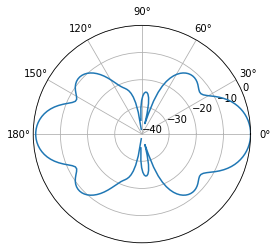

In [58]:
# compare with Fig. 12.23
plt.figure()
a0 = plt.subplot(111, projection='polar')
plt.plot(angles, dirnlty)
plt.ylim(-40,0);plt.yticks(np.arange(-40,10,10))
plt.xticks(np.radians(np.arange(0,210,30)))

### Progress notes
* After having implemented the code in Chapter 12, I'm still getting weird directionality results. Even though I increase the $N$ from 10 to 50, and even 100, it doesn't seem to change the final results, which don't match Fig. 12.23 at all. Perhaps $N$ is not the issue at hand but rather the numerical precision at which the numbers need to be represented.  This guess is based on the Tim Mellow code, which specified very high numeric precisions with 300 place decimal representations. The standard ```lambdify``` default is to convert the expression into a numpy or scipy float-based function. 
* 


In [59]:
from sympy import sinc

In [60]:
t = symbols('t', real=True)
def nsinc(t):
    "normalized sinc function"
    return sinc(pi * t)

nsinc(t).integrate(meijerg=True)


Si(pi*t)/pi

In [61]:
Integral(sinc(pi*t)).doit(meijerg=True)

Si(pi*t)/pi